In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output
import matplotlib.pyplot as plt
import pathlib

In [2]:
tf.__version__

'2.6.0'

In [114]:
def train_val_test_split(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

def display(imgtensor, lab=None):
    plt.figure(figsize=(10, 10))
    # plt.subplot(1, numimgs, i+1)
    CLASS = ['Kelvin', 'No Kelvin']
    if lab is not None:
        plt.title(f"label: {CLASS[lab]}")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgtensor), cmap='gray')
    plt.axis('off')
    plt.show()

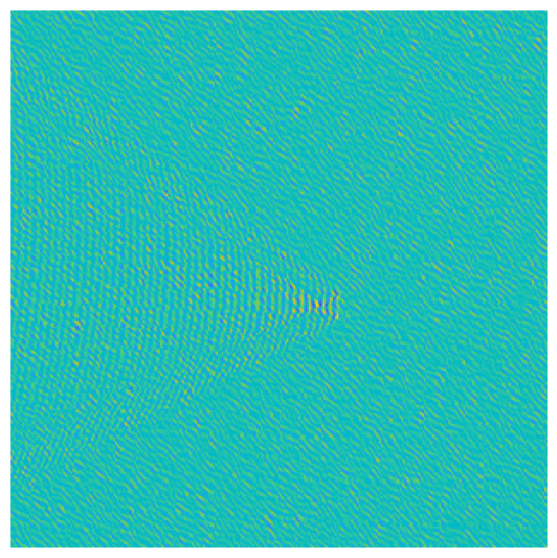

In [116]:
img = keras.utils.load_img('/srv/scratch/kelvinwakes/imgdata/ship_wake_photos8/noisyKelvin/1_Gauss_Kelvin_image.png')
shape = img.size
display(img)

In [150]:
750%24

6

In [162]:
BATCH_SIZE=8
imgdata = tf.keras.utils.image_dataset_from_directory("/srv/scratch/kelvinwakes/imgdata/ship_wake_photos8", 
                                                      image_size=shape,
                                                      color_mode='grayscale',
                                                      batch_size=BATCH_SIZE, 
                                                      seed=20220317,#date                                          
                                                     )
imgdata.cardinality().numpy()

Found 750 files belonging to 2 classes.


94

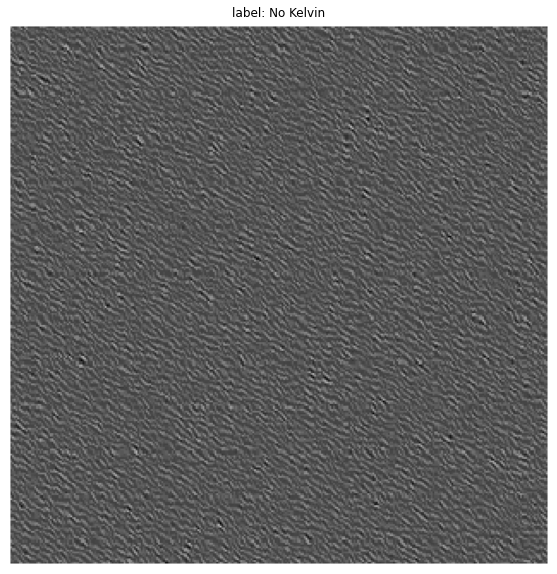

In [163]:
for img, lab in imgdata.take(1):
    i=BATCH_SIZE-1
    # print(img[i].shape, lab[i].numpy())
    display(img[i], lab=lab[i].numpy())

In [164]:
DS_SIZE = len(imgdata)
train_ds, val_ds, test_ds = train_val_test_split(imgdata, ds_size=DS_SIZE)
len(train_ds), len(val_ds), len(test_ds)

(75, 9, 10)

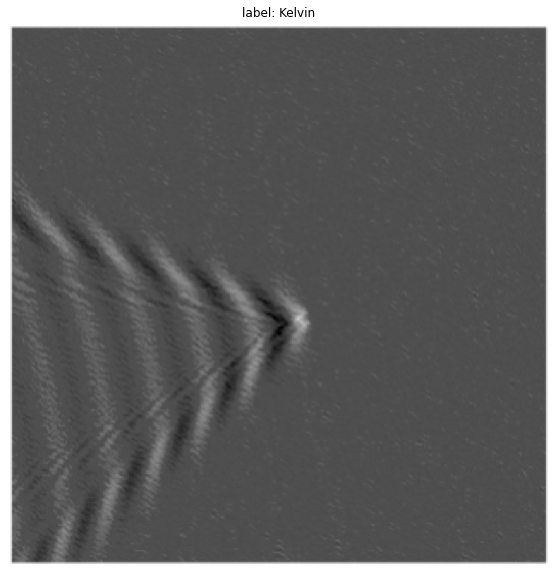